In [2]:
# GPyTorch Imports
import gpytorch
from gpytorch.models import ExactGP, IndependentModelList
from gpytorch.means import ConstantMean, MultitaskMean
from gpytorch.kernels import ScaleKernel, MultitaskKernel
from gpytorch.kernels import RBFKernel, RBFKernel, ProductKernel
from gpytorch.likelihoods import GaussianLikelihood, LikelihoodList, MultitaskGaussianLikelihood
from gpytorch.mlls import SumMarginalLogLikelihood, ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal, MultitaskMultivariateNormal

# PyTorch
import torch

# Math, avoiding memory leak, and timing
import math
import gc
import math

## Full Input, Batched Model

In [3]:

class BatchedGP(ExactGP):
    """Class for creating batched Gaussian Process Regression models.  Ideal candidate if
    using GPU-based acceleration such as CUDA for training.
    Parameters:
        train_x (torch.tensor): The training features used for Gaussian Process
            Regression.  These features will take shape (B * YD, N, XD), where:
                (i) B is the batch dimension - minibatch size
                (ii) N is the number of data points per GPR - the neighbors considered
                (iii) XD is the dimension of the features (d_state + d_action)
                (iv) YD is the dimension of the labels (d_reward + d_state)
            The features of train_x are tiled YD times along the first dimension.
        train_y (torch.tensor): The training labels used for Gaussian Process
            Regression.  These features will take shape (B * YD, N), where:
                (i) B is the batch dimension - minibatch size
                (ii) N is the number of data points per GPR - the neighbors considered
                (iii) YD is the dimension of the labels (d_reward + d_state)
            The features of train_y are stacked.
        likelihood (gpytorch.likelihoods.GaussianLikelihood): A likelihood object
            used for training and predicting samples with the BatchedGP model.
        shape (int):  The batch shape used for creating this BatchedGP model.
            This corresponds to the number of samples we wish to interpolate.
        output_device (str):  The device on which the GPR will be trained on.
        use_ard (bool):  Whether to use Automatic Relevance Determination (ARD)
            for the lengthscale parameter, i.e. a weighting for each input dimension.
            Defaults to False.
    """
    def __init__(self, train_x, train_y, likelihood, shape, output_device, use_ard=False):

        # Run constructor of superclass
        super(BatchedGP, self).__init__(train_x, train_y, likelihood)

        # Determine if using ARD
        ard_num_dims = None
        if use_ard:
            ard_num_dims = train_x.shape[-1]

        # Create the mean and covariance modules
        self.shape = torch.Size([shape])
        self.mean_module = ConstantMean(batch_shape=self.shape)
        self.base_kernel = RBFKernel(batch_shape=self.shape,
                                        ard_num_dims=ard_num_dims)
        self.covar_module = ScaleKernel(self.base_kernel,
                                        batch_shape=self.shape,
                                        output_device=output_device)

    def forward(self, x):
        """Forward pass method for making predictions through the model.  The
        mean and covariance are each computed to produce a MV distribution.
        Parameters:
            x (torch.tensor): The tensor for which we predict a mean and
                covariance used the BatchedGP model.
        Returns:
            mv_normal (gpytorch.distributions.MultivariateNormal): A Multivariate
                Normal distribution with parameters for mean and covariance computed
                at x.
        """
        mean_x = self.mean_module(x)  # Compute the mean at x
        covar_x = self.covar_module(x)  # Compute the covariance at x
        return MultivariateNormal(mean_x, covar_x)

## Factored Kernel Model

In [4]:
class CompositeBatchedGP(ExactGP):
    """Class for creating batched Gaussian Process Regression models.  Ideal candidate if
    using GPU-based acceleration such as CUDA for training.
    This kernel produces a composite kernel that multiplies actions times states,
    i.e. we have a different kernel for both the actions and states.  In turn,
    the composite kernel is then multiplied by a Scale kernel.
    Parameters:
        train_x (torch.tensor): The training features used for Gaussian Process
            Regression.  These features will take shape (B * YD, N, XD), where:
                (i) B is the batch dimension - minibatch size
                (ii) N is the number of data points per GPR - the neighbors considered
                (iii) XD is the dimension of the features (d_state + d_action)
                (iv) YD is the dimension of the labels (d_reward + d_state)
            The features of train_x are tiled YD times along the first dimension.
        train_y (torch.tensor): The training labels used for Gaussian Process
            Regression.  These features will take shape (B * YD, N), where:
                (i) B is the batch dimension - minibatch size
                (ii) N is the number of data points per GPR - the neighbors considered
                (iii) YD is the dimension of the labels (d_reward + d_state)
            The features of train_y are stacked.
        likelihood (gpytorch.likelihoods.GaussianLikelihood): A likelihood object
            used for training and predicting samples with the BatchedGP model.
        shape (int):  The batch shape used for creating this BatchedGP model.
            This corresponds to the number of samples we wish to interpolate.
        output_device (str):  The device on which the GPR will be trained on.
        use_ard (bool):  Whether to use Automatic Relevance Determination (ARD)
            for the lengthscale parameter, i.e. a weighting for each input dimension.
            Defaults to False.
        ds (int): If using a composite kernel, ds specifies the dimensionality of
            the state.  Only applicable if composite_kernel is True.
    """
    def __init__(self, train_x, train_y, likelihood, shape, output_device,
                 use_ard=False, ds=None):

        # Run constructor of superclass
        super(CompositeBatchedGP, self).__init__(train_x, train_y, likelihood)

        # Check if ds is None, and if not, set
        if ds is None:
            raise Exception("No dimension for state specified.  Please specify ds.")
        self.ds = ds

        # Set active dimensions
        state_dims = torch.tensor([i for i in range(0, ds)])
        action_dims = torch.tensor([i for i in range(ds, train_x.shape[-1])])

        # Determine if using ARD
        state_ard_num_dims = None
        action_ard_num_dims = None
        if use_ard:
            state_ard_num_dims = ds
            action_ard_num_dims = train_x.shape[-1] - ds

        # Create the mean and covariance modules
        self.shape = torch.Size([shape])

        # Construct mean module
        self.mean_module = ConstantMean(batch_shape=self.shape)

        # Construct state kernel
        self.state_base_kernel = RBFKernel(batch_shape=self.shape,
                                              active_dims=state_dims,
                                              ard_num_dims=state_ard_num_dims)

        # Construct action kernel
        self.action_base_kernel = RBFKernel(batch_shape=self.shape,
                                               active_dims=action_dims,
                                               ard_num_dims=action_ard_num_dims)

        # Construct composite kernel
        self.composite_kernel = self.state_base_kernel * self.action_base_kernel
        self.covar_module = ScaleKernel(self.composite_kernel,
                                        batch_shape=self.shape,
                                        output_device=output_device)


    def forward(self, x):
        """Forward pass method for making predictions through the model.  The
        mean and covariance are each computed to produce a MV distribution.
        Parameters:
            x (torch.tensor): The tensor for which we predict a mean and
                covariance used the BatchedGP model.
        Returns:
            mv_normal (gpytorch.distributions.MultivariateNormal): A Multivariate
                Normal distribution with parameters for mean and covariance computed
                at x.
        """
        # Compute mean and covariance in batched form
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

## Preprocessing Data

In [5]:
# Preprocess batch data
B, N, XD = Zs.shape
YD = Ys.shape[-1]
batch_shape = B * YD

if use_cuda:  # If GPU available
    output_device = torch.device('cuda:0')  # GPU

# Format the training features - tile and reshape
train_x = torch.tensor(Zs, device=output_device)
train_x = train_x.repeat((YD, 1, 1))

# Format the training labels - reshape
train_y = torch.vstack(
    [torch.tensor(Ys, device=output_device)[..., i] for i in range(YD)])
# train_x.shape
# --> (B*D, N, C)
# train_y.shape
# --> (B*D, N)

NameError: name 'Zs' is not defined

## Training Batched, Multidimensional GPR Models

In [6]:
def train_gp_batched_scalar(Zs, Ys, use_cuda=False, epochs=10,
                            lr=0.1, thr=0, use_ard=False, composite_kernel=False,
                            ds=None, global_hyperparams=False,
                            model_hyperparams=None):
    """Computes a Gaussian Process object using GPyTorch. Each outcome is
    modeled as a single scalar outcome.
    Parameters:
        Zs (np.array): Array of inputs of expanded shape (B, N, XD), where B is
            the size of the minibatch, N is the number of data points in each
            GP (the number of neighbors we consider in IER), and XD is the
            dimensionality of the state-action space of the environment.
        Ys (np.array): Array of predicted values of shape (B, N, YD), where B is the
            size of the minibatch and N is the number of data points in each
            GP (the number of neighbors we consider in IER), and YD is the
            dimensionality of the state-reward space of the environment.
        use_cuda (bool): Whether to use CUDA for GPU acceleration with PyTorch
            during the optimization step.  Defaults to False.
        epochs (int):  The number of epochs to train the batched GPs over.
            Defaults to 10.
        lr (float):  The learning rate to use for the Adam optimizer to train
            the batched GPs.
        thr (float):  The mll threshold at which to stop training.  Defaults to 0.
        use_ard (bool):  Whether to use Automatic Relevance Determination (ARD)
            for the lengthscale parameter, i.e. a weighting for each input dimension.
            Defaults to False.
        composite_kernel (bool):  Whether to use a composite kernel that computes
            the product between states and actions to compute the variance of y.
        ds (int): If using a composite kernel, ds specifies the dimensionality of
            the state.  Only applicable if composite_kernel is True.
        global_hyperparams (bool):  Whether to use a single set of hyperparameters
            over an entire model.  Defaults to False.
        model_hyperparams (dict):  A dictionary of hyperparameters to use for
            initializing a model.  Defaults to None.
    Returns:
        model (BatchedGP): A GPR model of BatchedGP type with which to generate
            synthetic predictions of rewards and next states.
        likelihood (GaussianLikelihood): A likelihood object used for training
            and predicting samples with the BatchedGP model.
    """
    # Preprocess batch data
    B, N, XD = Zs.shape
    YD = Ys.shape[-1]
    batch_shape = B * YD

    if use_cuda:  # If GPU available
        output_device = torch.device('cuda:0')  # GPU

    # Format the training features - tile and reshape
    train_x = torch.tensor(Zs, device=output_device)
    train_x = train_x.repeat((YD, 1, 1))

    # Format the training labels - reshape
    train_y = torch.vstack(
        [torch.tensor(Ys, device=output_device)[..., i] for i in range(YD)])

    # initialize likelihood and model
    likelihood = GaussianLikelihood(batch_shape=torch.Size([batch_shape]))

    # Determine which type of kernel to use
    if composite_kernel:
        model = CompositeBatchedGP(train_x, train_y, likelihood, batch_shape,
                          output_device, use_ard=use_ard, ds=ds)
    else:
        model = BatchedGP(train_x, train_y, likelihood, batch_shape,
                          output_device, use_ard=use_ard)

    # Initialize the model with hyperparameters
    if model_hyperparams is not None:
        model.initialize(**model_hyperparams)

    # Determine if we need to optimize hyperparameters
    if global_hyperparams:
        if use_cuda:  # Send everything to GPU for training
            model = model.cuda().eval()

            # Empty the cache from GPU
            torch.cuda.empty_cache()
            gc.collect()  # NOTE: Critical to avoid GPU leak
            del train_x, train_y, Zs, Ys, likelihood

        return model, model.likelihood

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # "Loss" for GPs - the marginal log likelihood
    mll = ExactMarginalLogLikelihood(likelihood, model)

    if use_cuda:  # Send everything to GPU for training
        model = model.cuda()
        likelihood = likelihood.cuda()
        train_x = train_x.cuda()
        train_y = train_y.cuda()
        mll = mll.cuda()

    def epoch_train(j):
        """Helper function for running training in the optimization loop.  Note
        that the model and likelihood are updated outside of this function as well.
        Parameters:
            j (int):  The epoch number.
        Returns:
            item_loss (float):  The numeric representation (detached from the
                computation graph) of the loss from the jth epoch.
        """
        optimizer.zero_grad()  # Zero gradients
        output = model(train_x)  # Forwardpass
        loss = -mll(output, train_y).sum()  # Compute ind. losses + aggregate
        loss.backward()  # Backpropagate gradients
        item_loss = loss.item()  # Extract loss (detached from comp. graph)
        optimizer.step()  # Update weights
        optimizer.zero_grad()  # Zero gradients
        gc.collect()  # NOTE: Critical to avoid GPU leak
        return item_loss

    # Run the optimization loop
    for i in range(epochs):
        loss_i = epoch_train(i)
        if i % 10 == 0:
            print("LOSS EPOCH {}: {}".format(i, loss_i))
        if loss_i < thr:  # If we reach a certain loss threshold, stop training
            break

    # Empty the cache from GPU
    torch.cuda.empty_cache()

    return model, likelihood

## Testing GP

In [7]:
def train_gp_batched_scalar(Zs, Ys, use_cuda=False, epochs=10,
                            lr=0.1, thr=0, use_ard=False, composite_kernel=False,
                            ds=None, global_hyperparams=False,
                            model_hyperparams=None):
    """Computes a Gaussian Process object using GPyTorch. Each outcome is
    modeled as a single scalar outcome.
    Parameters:
        Zs (np.array): Array of inputs of expanded shape (B, N, XD), where B is
            the size of the minibatch, N is the number of data points in each
            GP (the number of neighbors we consider in IER), and XD is the
            dimensionality of the state-action space of the environment.
        Ys (np.array): Array of predicted values of shape (B, N, YD), where B is the
            size of the minibatch and N is the number of data points in each
            GP (the number of neighbors we consider in IER), and YD is the
            dimensionality of the state-reward space of the environment.
        use_cuda (bool): Whether to use CUDA for GPU acceleration with PyTorch
            during the optimization step.  Defaults to False.
        epochs (int):  The number of epochs to train the batched GPs over.
            Defaults to 10.
        lr (float):  The learning rate to use for the Adam optimizer to train
            the batched GPs.
        thr (float):  The mll threshold at which to stop training.  Defaults to 0.
        use_ard (bool):  Whether to use Automatic Relevance Determination (ARD)
            for the lengthscale parameter, i.e. a weighting for each input dimension.
            Defaults to False.
        composite_kernel (bool):  Whether to use a composite kernel that computes
            the product between states and actions to compute the variance of y.
        ds (int): If using a composite kernel, ds specifies the dimensionality of
            the state.  Only applicable if composite_kernel is True.
        global_hyperparams (bool):  Whether to use a single set of hyperparameters
            over an entire model.  Defaults to False.
        model_hyperparams (dict):  A dictionary of hyperparameters to use for
            initializing a model.  Defaults to None.
    Returns:
        model (BatchedGP): A GPR model of BatchedGP type with which to generate
            synthetic predictions of rewards and next states.
        likelihood (GaussianLikelihood): A likelihood object used for training
            and predicting samples with the BatchedGP model.
    """
    # Preprocess batch data
    B, N, XD = Zs.shape
    YD = Ys.shape[-1]
    batch_shape = B * YD

    if use_cuda:  # If GPU available
        output_device = torch.device('cuda:0')  # GPU

    # Format the training features - tile and reshape
    train_x = torch.tensor(Zs, device=output_device)
    train_x = train_x.repeat((YD, 1, 1))

    # Format the training labels - reshape
    train_y = torch.vstack(
        [torch.tensor(Ys, device=output_device)[..., i] for i in range(YD)])

    # initialize likelihood and model
    likelihood = GaussianLikelihood(batch_shape=torch.Size([batch_shape]))

    # Determine which type of kernel to use
    if composite_kernel:
        model = CompositeBatchedGP(train_x, train_y, likelihood, batch_shape,
                          output_device, use_ard=use_ard, ds=ds)
    else:
        model = BatchedGP(train_x, train_y, likelihood, batch_shape,
                          output_device, use_ard=use_ard)

    # Initialize the model with hyperparameters
    if model_hyperparams is not None:
        model.initialize(**model_hyperparams)

    # Determine if we need to optimize hyperparameters
    if global_hyperparams:
        if use_cuda:  # Send everything to GPU for training
            model = model.cuda().eval()

            # Empty the cache from GPU
            torch.cuda.empty_cache()
            gc.collect()  # NOTE: Critical to avoid GPU leak
            del train_x, train_y, Zs, Ys, likelihood

        return model, model.likelihood

    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # "Loss" for GPs - the marginal log likelihood
    mll = ExactMarginalLogLikelihood(likelihood, model)

    if use_cuda:  # Send everything to GPU for training
        model = model.cuda()
        likelihood = likelihood.cuda()
        train_x = train_x.cuda()
        train_y = train_y.cuda()
        mll = mll.cuda()

    def epoch_train(j):
        """Helper function for running training in the optimization loop.  Note
        that the model and likelihood are updated outside of this function as well.
        Parameters:
            j (int):  The epoch number.
        Returns:
            item_loss (float):  The numeric representation (detached from the
                computation graph) of the loss from the jth epoch.
        """
        optimizer.zero_grad()  # Zero gradients
        output = model(train_x)  # Forwardpass
        loss = -mll(output, train_y).sum()  # Compute ind. losses + aggregate
        loss.backward()  # Backpropagate gradients
        item_loss = loss.item()  # Extract loss (detached from comp. graph)
        optimizer.step()  # Update weights
        optimizer.zero_grad()  # Zero gradients
        gc.collect()  # NOTE: Critical to avoid GPU leak
        return item_loss

    # Run the optimization loop
    for i in range(epochs):
        loss_i = epoch_train(i)
        if i % 10 == 0:
            print("LOSS EPOCH {}: {}".format(i, loss_i))
        if loss_i < thr:  # If we reach a certain loss threshold, stop training
            break

    # Empty the cache from GPU
    torch.cuda.empty_cache()

    return model, likelihood

def preprocess_eval_inputs(Zs, d_y, device="cpu"):
    """Helper function to preprocess inputs for use with training
    targets and evaluation.
    Parameters:
        Zs (np.array): Array of inputs of expanded shape (B, N, XD), where B is
            the size of the minibatch, N is the number of data points in each
            GP (the number of neighbors we consider in IER), and XD is the
            dimensionality of the state-action space of the environment.
        d_y (int):  The dimensionality of the targets of GPR.
        device (str):  Device to output the tensor to.
    Returns:
        eval_x (torch.tensor):  Torch tensor of shape (B * YD, N, XD).  This
            tensor corresponding to a tiled set of inputs is used as input for
            the inference model in FP32 format.
    """
    # Preprocess batch data
    eval_x = torch.tensor(Zs, device=device).double()
    eval_x = eval_x.repeat((d_y, 1, 1))
    return eval_x

In [27]:
"""Main tester function."""
# Set parameters
B = 256  # Number of batches
N = 100  # Number of data points in each batch
# D = 3  # Dimension of X and Y data
D = 1  # Dimension of X and Y data
Ds = 1  # Dimensions for first factored kernel - only needed if factored kernel is used
EPOCHS = 50  # Number of iterations to perform optimization
THR = -1e5  # Training threshold (minimum)
USE_CUDA = torch.cuda.is_available()  # Hardware acceleraton
MEAN = 0  # Mean of data generated
SCALE = 1  # Variance of data generated
COMPOSITE_KERNEL = False  # Use a factored kernel
USE_ARD = True  # Use Automatic Relevance Determination in kernel
LR = 0.5  # Learning rate

# Create training data and labels
train_x_np = np.random.normal(loc=MEAN, scale=SCALE, size=(B, N, D))  # Randomly-generated data
train_y_np = np.sin(train_x_np)  # Analytic sine function

print(train_x_np.shape)
print(train_y_np.shape)

(256, 100, 1)
(256, 100, 1)


In [28]:
# GPyTorch training
start = time.time()
model, likelihood = train_gp_batched_scalar(train_x_np, train_y_np,
                                            use_cuda=USE_CUDA,
                                            composite_kernel=COMPOSITE_KERNEL,
                                            epochs=EPOCHS, lr=LR, thr=THR, ds=Ds,
                                            use_ard=USE_ARD)
end = time.time()
print("TRAINING TIME: {}".format(end - start))

LOSS EPOCH 0: 211.66286366182487
LOSS EPOCH 10: -362.33752818198684
LOSS EPOCH 20: -819.2689386239448
LOSS EPOCH 30: -862.3429451280454
LOSS EPOCH 40: -863.9960088393425
TRAINING TIME: 5.87066912651062


In [32]:
model.eval()
likelihood.eval()

# Now evaluate
test_x_np = np.random.normal(loc=MEAN, scale=SCALE, size=(B, 1, D))
train_x = preprocess_eval_inputs(train_x_np, train_y_np.shape[-1])
test_x = preprocess_eval_inputs(test_x_np, train_y_np.shape[-1])

# Put on GPU
if USE_CUDA:
    test_x = test_x.cuda()
    train_x = train_x.cuda()

# Run Inference
with torch.no_grad():
    f_preds = model(test_x)
    observed_pred = likelihood(model(test_x))
    mean = observed_pred.mean
    variance = observed_pred.variance


In [39]:
print(train_x.size())
print(test_x.size())

# output = mean.cpu().detach().numpy()
# out_y = np.squeeze(np.array([output[i::B] for i in range(B)]))

# print(output.shape)
print(out_y.shape)
# print(output[:10])
# print(out_y[:10])

torch.Size([256, 100, 1])
torch.Size([256, 1, 1])
(256,)


(256,)


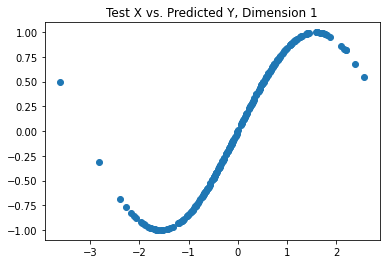

ValueError: x and y must be equal-length 1D arrays

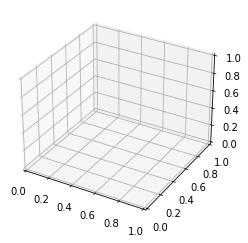

In [41]:
# Compute mean and unstack
output = mean.cpu().detach().numpy()
out_y = np.squeeze(np.array([output[i::B] for i in range(B)]))

# Reformat, get analytic y, and plot
x_plot = np.squeeze(test_x_np)
y_plot_gt = np.sin(x_plot)
# plt.scatter(x_plot[:, DIM], out_y[:, DIM])
plt.scatter(x_plot, out_y)
plt.title("Test X vs. Predicted Y, Dimension {}".format(DIM))
plt.show()

# Creating color map
my_cmap_analytic = plt.get_cmap('hot')
my_cmap_predicted = plt.get_cmap('cool')

# Plot ground truth
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(x_plot[..., 0], x_plot[..., 1], y_plot_gt[..., DIM],
                antialiased=True, cmap=my_cmap_analytic)
plt.title("Analytic, Ground Truth Surface, Dimension {}".format(DIM))
plt.show()

# Plot the predicted values
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(x_plot[..., 0], x_plot[..., 1], out_y[..., DIM],
                antialiased=True, cmap=my_cmap_predicted)
plt.title("Predicted Surface, Dimension {}".format(DIM))
plt.show()


In [ ]:

# Compute average RMSE
y_true = np.squeeze(np.sin(test_x_np))
y_pred = out_y
rmse = np.sqrt(mse(y_true, y_pred))
print("RMSE: {}".format(rmse))
# return rmse

In [ ]:

# # Generate plots over different dimensions
# # for DIM, c in zip([0, 1, 2], ["r", "g", "b"]):
# for DIM, c in zip([0, 1], ["r", "g"]):
#     # Compute mean and unstack
#     output = mean.cpu().detach().numpy()
#     out_y = np.squeeze(np.array([output[i::B] for i in range(B)]))

#     # Reformat, get analytic y, and plot
#     x_plot = np.squeeze(test_x_np)
#     y_plot_gt = np.sin(x_plot)
#     plt.scatter(x_plot[:, DIM], out_y[:, DIM])
#     plt.title("Test X vs. Predicted Y, Dimension {}".format(DIM))
#     plt.show()

#     # Creating color map
#     my_cmap_analytic = plt.get_cmap('hot')
#     my_cmap_predicted = plt.get_cmap('cool')

#     # Plot ground truth
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     ax.plot_trisurf(x_plot[..., 0], x_plot[..., 1], y_plot_gt[..., DIM],
#                     antialiased=True, cmap=my_cmap_analytic)
#     plt.title("Analytic, Ground Truth Surface, Dimension {}".format(DIM))
#     plt.show()

#     # Plot the predicted values
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     ax.plot_trisurf(x_plot[..., 0], x_plot[..., 1], out_y[..., DIM],
#                     antialiased=True, cmap=my_cmap_predicted)
#     plt.title("Predicted Surface, Dimension {}".format(DIM))
#     plt.show()

# # Compute average RMSE
# y_true = np.squeeze(np.sin(test_x_np))
# y_pred = out_y
# rmse = np.sqrt(mse(y_true, y_pred))
# print("RMSE: {}".format(rmse))
# # return rmse

LOSS EPOCH 0: 798.3214888284384
LOSS EPOCH 10: -946.3424440553854
LOSS EPOCH 20: -2193.947563876648
LOSS EPOCH 30: -2359.3673910377674
LOSS EPOCH 40: -2395.7085862808267
TRAINING TIME: 12.891817331314087


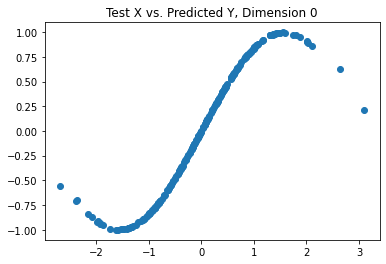

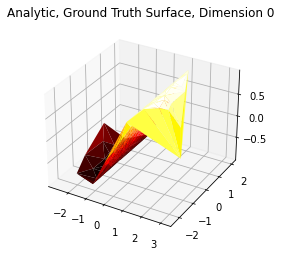

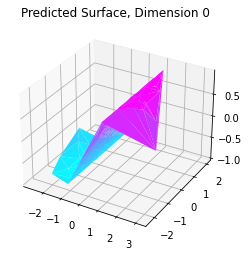

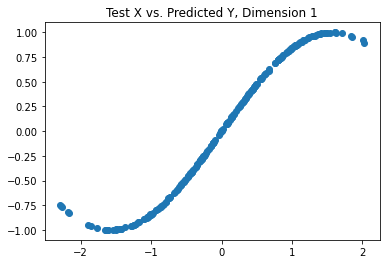

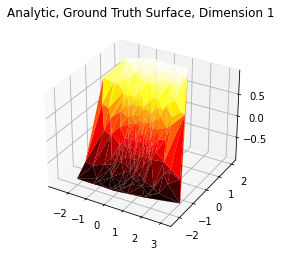

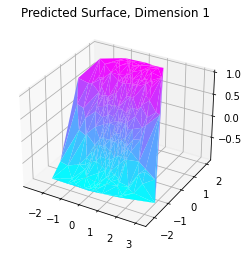

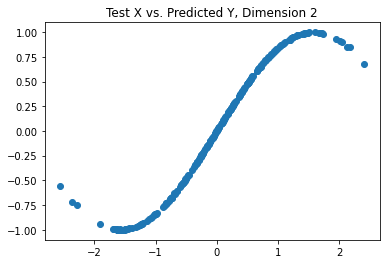

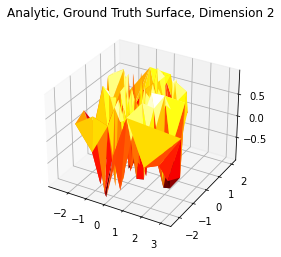

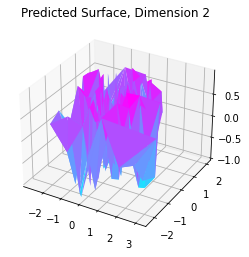

RMSE: 0.009514156508234275
LOSS EPOCH 0: 800.0246595400166
LOSS EPOCH 10: -943.6514498662062
LOSS EPOCH 20: -2189.90367181116
LOSS EPOCH 30: -2355.2593275542004
LOSS EPOCH 40: -2391.953538257622
TRAINING TIME: 11.28829312324524


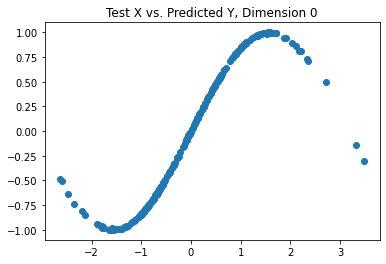

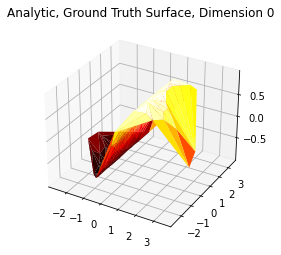

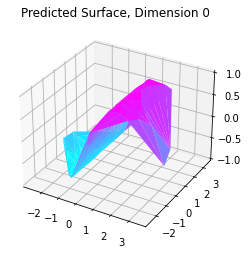

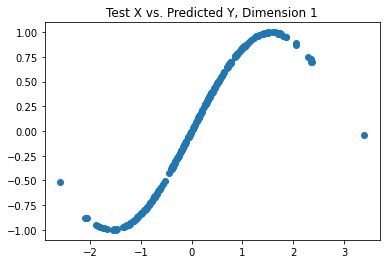

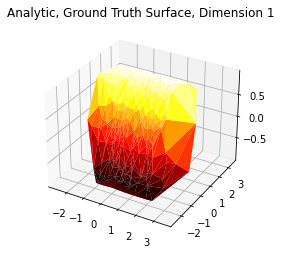

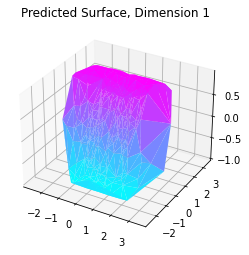

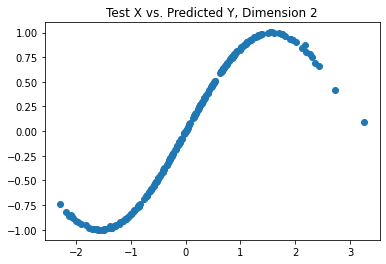

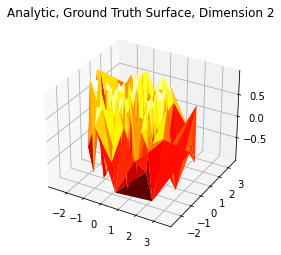

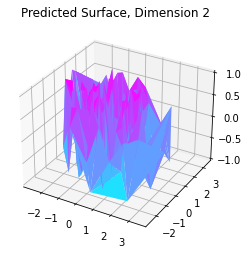

RMSE: 0.012227608388300813
LOSS EPOCH 0: 799.3554983878761
LOSS EPOCH 10: -945.3565565802105
LOSS EPOCH 20: -2191.9449644203387
LOSS EPOCH 30: -2357.334850195824
LOSS EPOCH 40: -2393.9337132994747
TRAINING TIME: 11.279056549072266


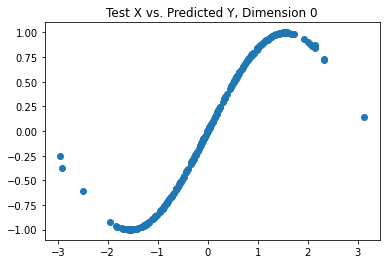

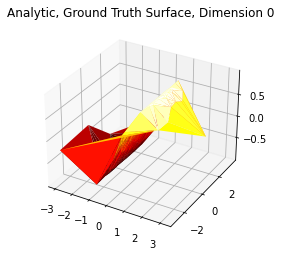

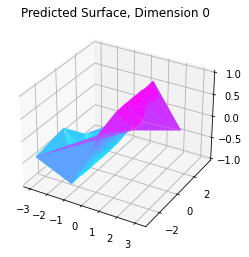

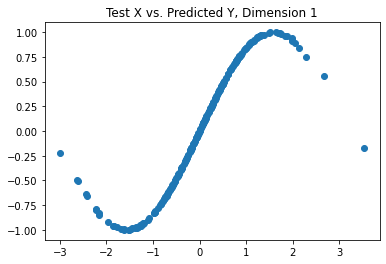

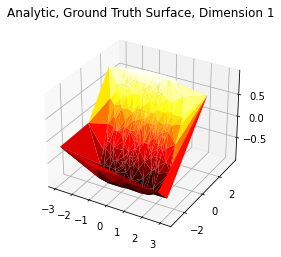

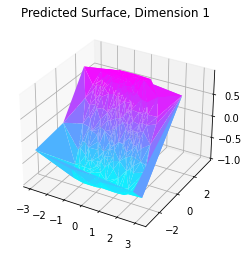

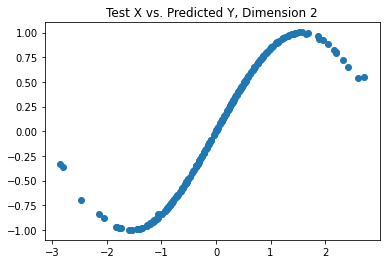

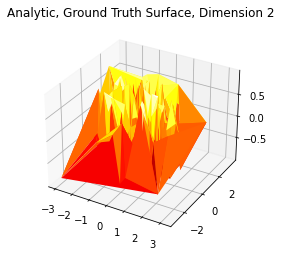

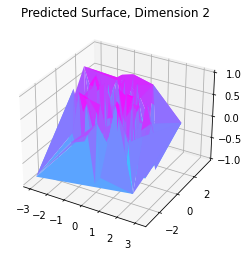

RMSE: 0.013777196855933671
LOSS EPOCH 0: 799.6589367902885
LOSS EPOCH 10: -943.6163315159989
LOSS EPOCH 20: -2190.0810145794194
LOSS EPOCH 30: -2355.534597547202
LOSS EPOCH 40: -2392.156688895126
TRAINING TIME: 10.550209760665894


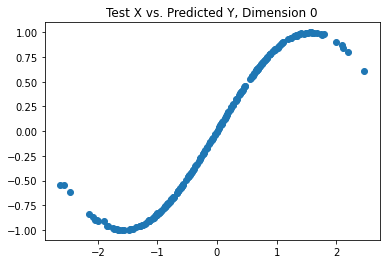

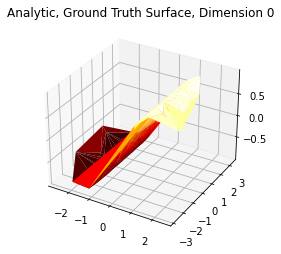

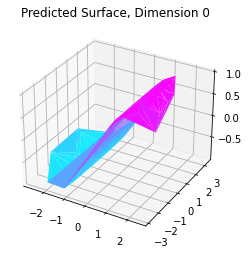

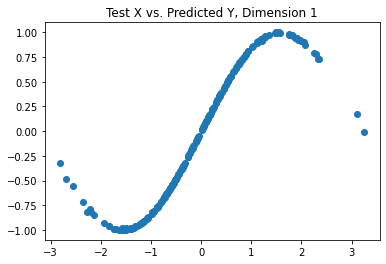

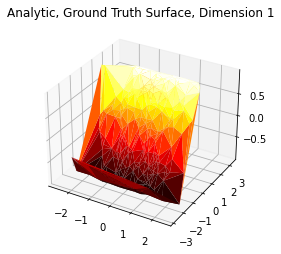

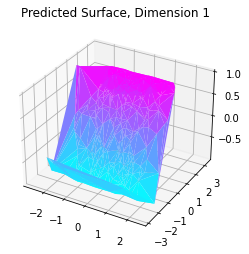

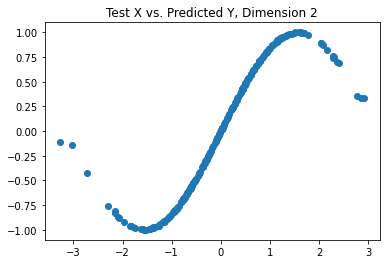

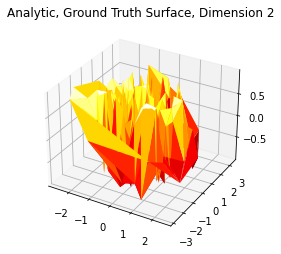

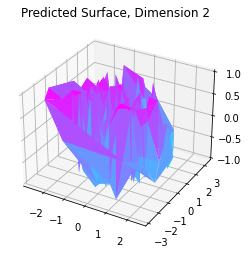

RMSE: 0.012753647724250326
LOSS EPOCH 0: 799.0964837700653
LOSS EPOCH 10: -945.9550759537544
LOSS EPOCH 20: -2193.1015373690852
LOSS EPOCH 30: -2358.6269639545703
LOSS EPOCH 40: -2395.0951262787617
TRAINING TIME: 10.871001243591309


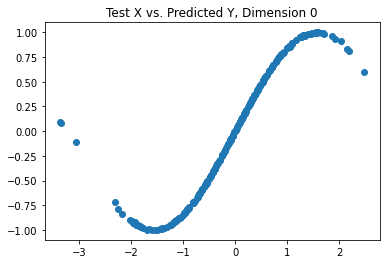

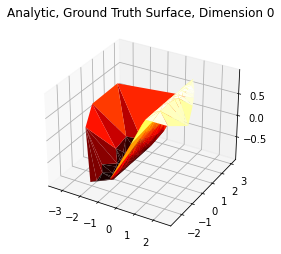

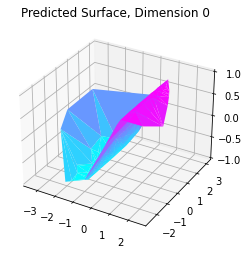

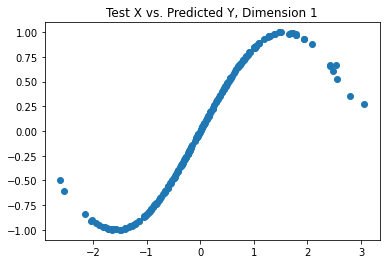

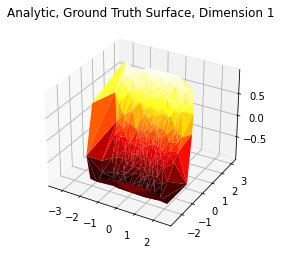

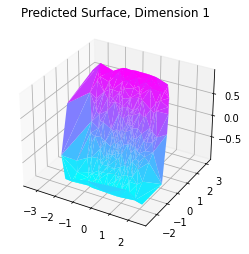

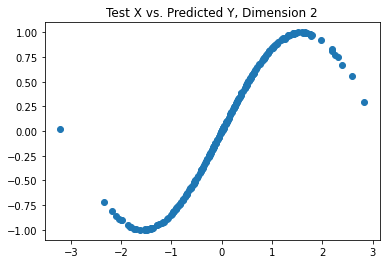

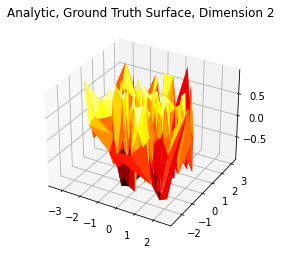

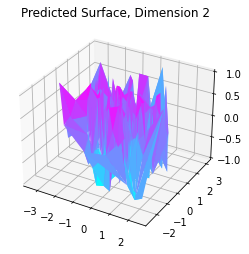

RMSE: 0.011405839379800383
LOSS EPOCH 0: 799.4878947321931
LOSS EPOCH 10: -944.610588898352
LOSS EPOCH 20: -2191.0009535194913
LOSS EPOCH 30: -2356.4755506912124
LOSS EPOCH 40: -2393.111234154097
TRAINING TIME: 11.790483951568604


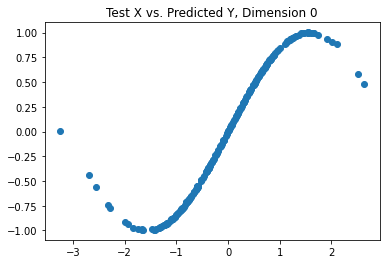

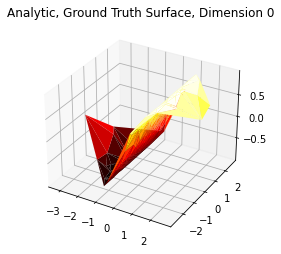

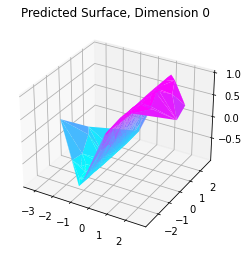

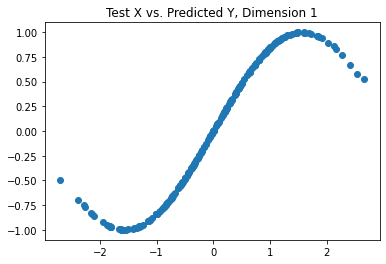

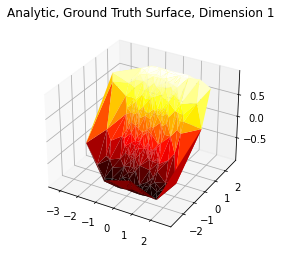

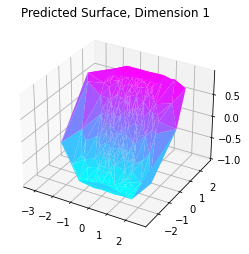

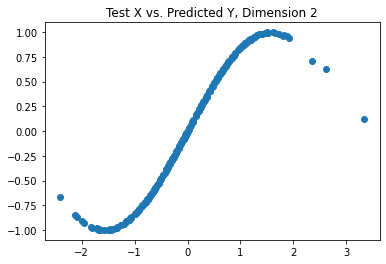

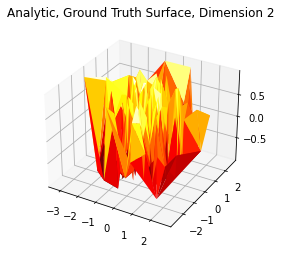

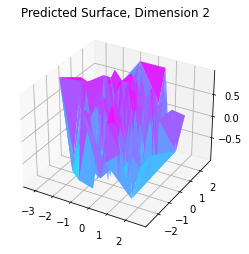

RMSE: 0.013552790353638383
LOSS EPOCH 0: 800.1035893427534
LOSS EPOCH 10: -944.0474329671868
LOSS EPOCH 20: -2190.400824910558
LOSS EPOCH 30: -2355.8864677455813
LOSS EPOCH 40: -2392.618809468236
TRAINING TIME: 11.321528434753418


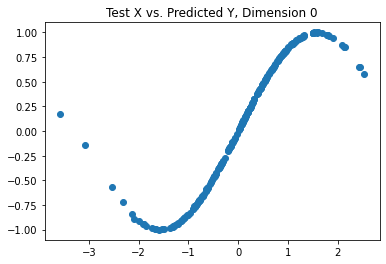

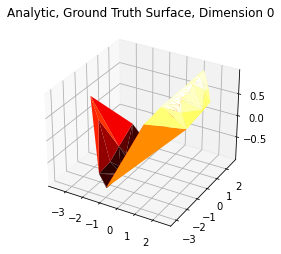

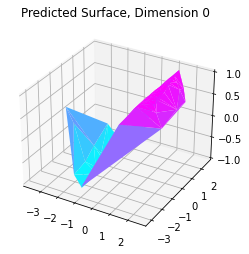

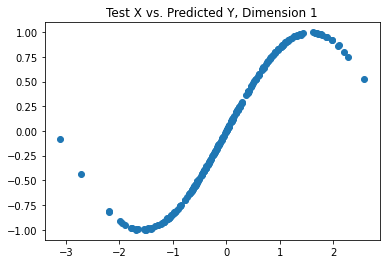

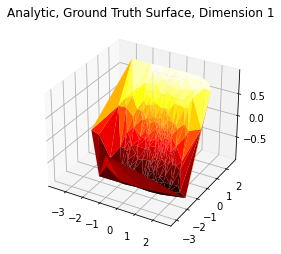

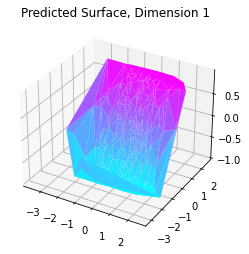

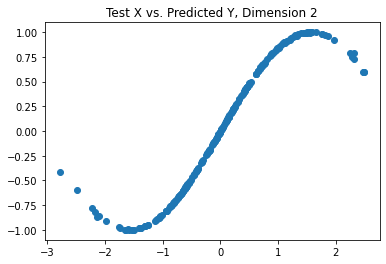

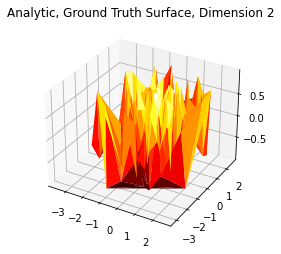

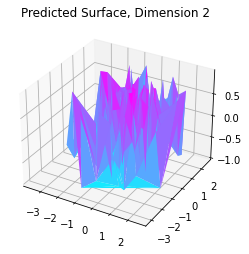

RMSE: 0.010555719012902866
LOSS EPOCH 0: 799.9622150479815
LOSS EPOCH 10: -943.94104704583
LOSS EPOCH 20: -2190.1157696444307
LOSS EPOCH 30: -2355.557807002163
LOSS EPOCH 40: -2392.259791503965
TRAINING TIME: 12.094502449035645


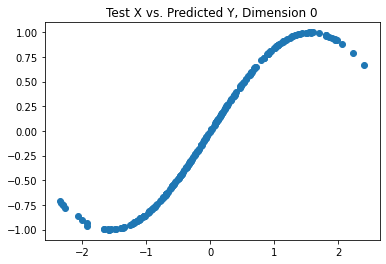

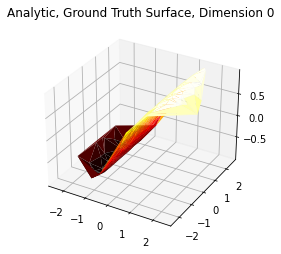

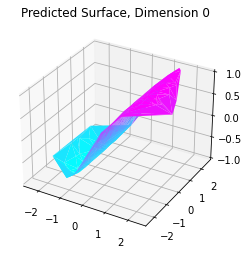

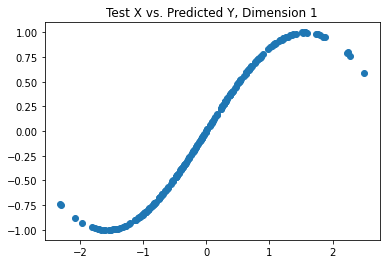

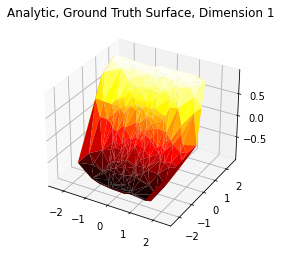

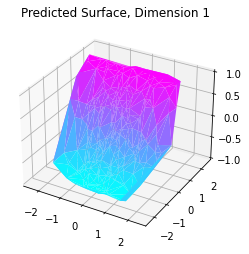

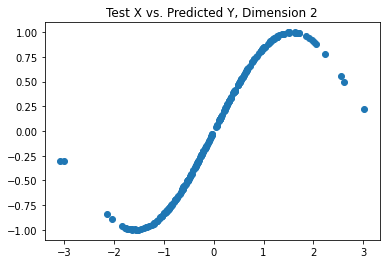

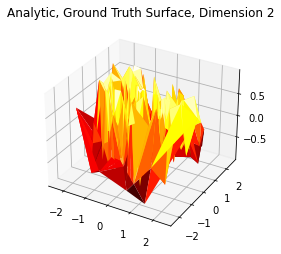

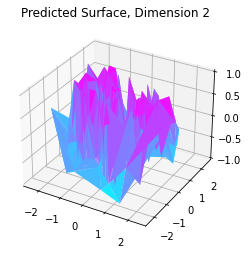

RMSE: 0.011697547428199352
LOSS EPOCH 0: 799.2260449763114
LOSS EPOCH 10: -945.3259425775675
LOSS EPOCH 20: -2192.190756300558
LOSS EPOCH 30: -2357.7495295411773
LOSS EPOCH 40: -2394.2197627654486
TRAINING TIME: 11.527451753616333


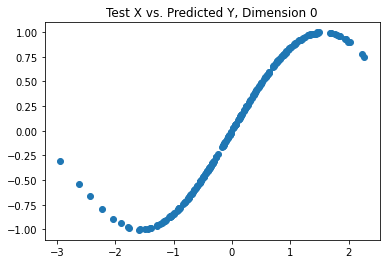

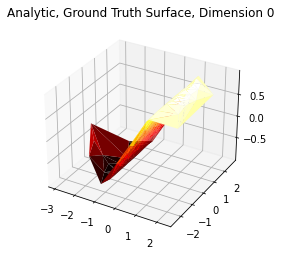

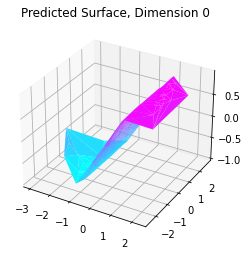

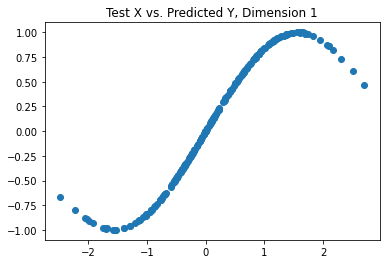

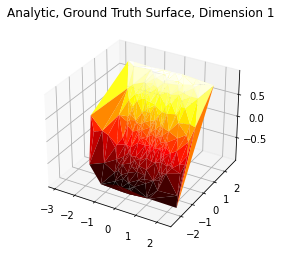

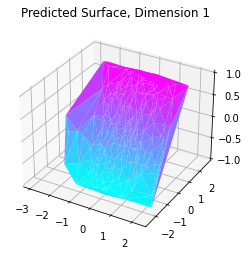

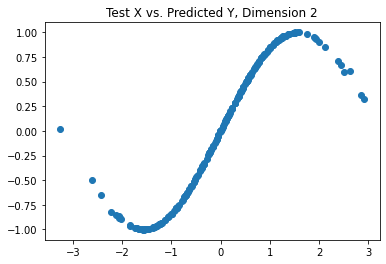

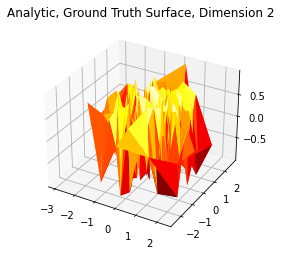

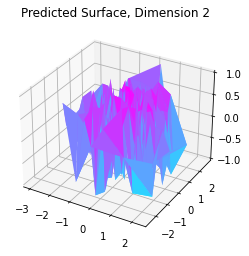

RMSE: 0.009364214601468622
LOSS EPOCH 0: 799.4002815011233
LOSS EPOCH 10: -945.8249616055384
LOSS EPOCH 20: -2193.053456666213
LOSS EPOCH 30: -2358.484471261586
LOSS EPOCH 40: -2394.9687228297844
TRAINING TIME: 11.866736650466919


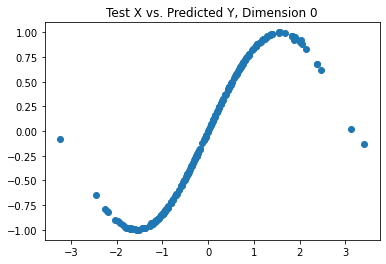

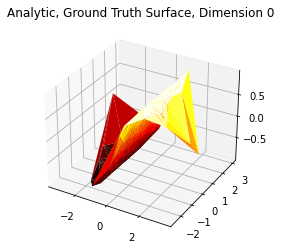

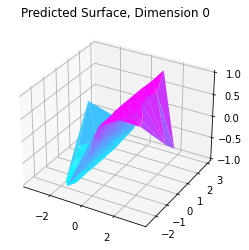

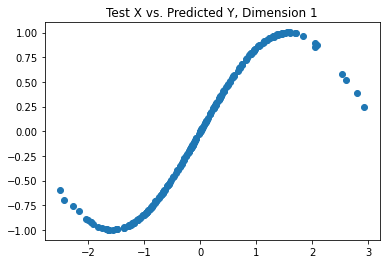

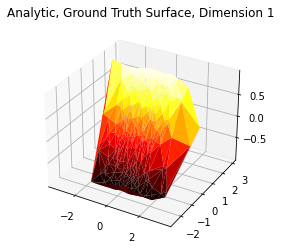

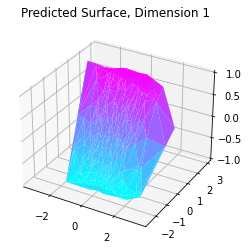

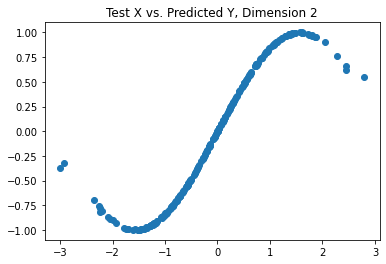

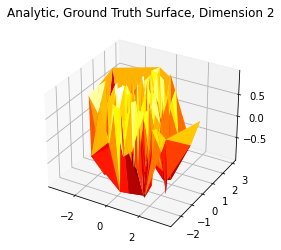

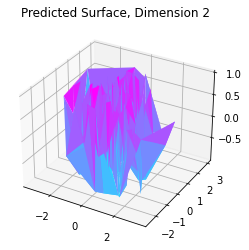

RMSE: 0.015291887545876725
AVERAGED RMSE: 0.01201406077986054


In [8]:

# """Tester script for GPyTorch using analytic sine functions."""

# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# import time
# from sklearn.metrics import mean_squared_error as mse


# def main():
#     """Main tester function."""
#     # Set parameters
#     B = 256  # Number of batches
#     N = 100  # Number of data points in each batch
#     D = 3  # Dimension of X and Y data
#     Ds = 1  # Dimensions for first factored kernel - only needed if factored kernel is used
#     EPOCHS = 50  # Number of iterations to perform optimization
#     THR = -1e5  # Training threshold (minimum)
#     USE_CUDA = torch.cuda.is_available()  # Hardware acceleraton
#     MEAN = 0  # Mean of data generated
#     SCALE = 1  # Variance of data generated
#     COMPOSITE_KERNEL = False  # Use a factored kernel
#     USE_ARD = True  # Use Automatic Relevance Determination in kernel
#     LR = 0.5  # Learning rate

#     # Create training data and labels
#     train_x_np = np.random.normal(loc=MEAN, scale=SCALE, size=(B, N, D))  # Randomly-generated data
#     train_y_np = np.sin(train_x_np)  # Analytic sine function

#     # GPyTorch training
#     start = time.time()
#     model, likelihood = train_gp_batched_scalar(train_x_np, train_y_np,
#                                                 use_cuda=USE_CUDA,
#                                                 composite_kernel=COMPOSITE_KERNEL,
#                                                 epochs=EPOCHS, lr=LR, thr=THR, ds=Ds,
#                                                 use_ard=USE_ARD)
#     end = time.time()
#     print("TRAINING TIME: {}".format(end - start))
#     model.eval()
#     likelihood.eval()
    
#     # Now evaluate
#     test_x_np = np.random.normal(loc=MEAN, scale=SCALE, size=(B, 1, D))
#     train_x = preprocess_eval_inputs(train_x_np, train_y_np.shape[-1])
#     test_x = preprocess_eval_inputs(test_x_np, train_y_np.shape[-1])
    
#     # Put on GPU
#     if USE_CUDA:
#         test_x = test_x.cuda()
#         train_x = train_x.cuda()
    
#     # Run Inference
#     with torch.no_grad():
#         f_preds = model(test_x)
#         observed_pred = likelihood(model(test_x))
#         mean = observed_pred.mean
#         variance = observed_pred.variance

#     # Generate plots over different dimensions
#     for DIM, c in zip([0, 1, 2], ["r", "g", "b"]):
#         # Compute mean and unstack
#         output = mean.cpu().detach().numpy()
#         out_y = np.squeeze(np.array([output[i::B] for i in range(B)]))

#         # Reformat, get analytic y, and plot
#         x_plot = np.squeeze(test_x_np)
#         y_plot_gt = np.sin(x_plot)
#         plt.scatter(x_plot[:, DIM], out_y[:, DIM])
#         plt.title("Test X vs. Predicted Y, Dimension {}".format(DIM))
#         plt.show()

#         # Creating color map
#         my_cmap_analytic = plt.get_cmap('hot')
#         my_cmap_predicted = plt.get_cmap('cool')

#         # Plot ground truth
#         fig = plt.figure()
#         ax = fig.add_subplot(111, projection='3d')
#         ax.plot_trisurf(x_plot[..., 0], x_plot[..., 1], y_plot_gt[..., DIM],
#                         antialiased=True, cmap=my_cmap_analytic)
#         plt.title("Analytic, Ground Truth Surface, Dimension {}".format(DIM))
#         plt.show()

#         # Plot the predicted values
#         fig = plt.figure()
#         ax = fig.add_subplot(111, projection='3d')
#         ax.plot_trisurf(x_plot[..., 0], x_plot[..., 1], out_y[..., DIM],
#                         antialiased=True, cmap=my_cmap_predicted)
#         plt.title("Predicted Surface, Dimension {}".format(DIM))
#         plt.show()

#     # Compute average RMSE
#     y_true = np.squeeze(np.sin(test_x_np))
#     y_pred = out_y
#     rmse = np.sqrt(mse(y_true, y_pred))
#     print("RMSE: {}".format(rmse))
#     return rmse






# if __name__ == '__main__':
#     all_rmses = []
#     for i in range(10):
#         all_rmses.append(main())
#     print("AVERAGED RMSE: {}".format(np.mean(all_rmses)))